In [48]:
# import libraries
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
from shapely import wkt
import itertools
from street_features import *

# Importing Randomly Created Coordinates data for Feature Engineering

## Open Street Maps

In [49]:
## Import Seattle street and map data
Seattle_poly = ox.gdf_from_place('Seattle, Washington')

# grab street data (roads and intersections) for entire city
sea_streets = ox.graph_from_place('Seattle, Washington', network_type = 'drive')
nodes, edges = ox.graph_to_gdfs(sea_streets)

In [50]:
#remove doubled road IDs, this is only 20 roads out of 22335, but they cause subsetting problems
sea_rds = remove_doubleID_streets(edges)

# grab subsets of roadtypes
sea_highways = sea_rds[sea_rds.highway == 'motorway']
sea_primary = sea_rds[sea_rds.highway == 'primary']
sea_secondary = sea_rds[sea_rds.highway == 'secondary']
sea_resid = sea_rds[sea_rds.highway == 'residential']

## Convert data to Geopandas frame and Subset on Seattle polygon grid

In [51]:
## Import walk_score data, create shapely points, and convert to geopandas dataframe
walk_df = pd.read_csv('Data/master_walk_score.csv', index_col=0)


geometry = [Point(xy) for xy in zip(walk_df.lon, walk_df.lat)]
walk_gdf = gpd.GeoDataFrame(walk_df, geometry=geometry, crs={'init' :'epsg:4326'})


#subset walk_score data in Seattle polygon grid
EDF_points = gpd.sjoin(walk_gdf, Seattle_poly, how="inner", op="intersects")
EDF_points = EDF_points.rename(index=str)

EDF_points = EDF_points.reset_index(drop=True)
EDF_points = EDF_points.drop(['index_right', 'bbox_east', 'bbox_north', 'bbox_south', 'bbox_west'], axis=1)
EDF_points.head(3)

,lat,lon,walk_score,GEOID,intersection_count,streets_per_node_avg,circuity_avg,street_length_avg,restaurant_count,school_count,park_count,bus_station_count,supermarket_count,pub_count,parkwide_count,restaurantwide_count,geometry,place_name
0,47.555176,-122.315722,71,53033010402,51,2.873016,1.027668,55.858171,15,5,0,9,2,5,34,25,POINT (-122.3157218098284 47.55517615550175),"Seattle, King County, Washington, USA"
1,47.644436,-122.341497,55,53033005400,4,3.000000,1.000050,54.406750,37,4,0,5,1,12,50,50,POINT (-122.3414969413906 47.64443555185601),"Seattle, King County, Washington, USA"
2,47.532400,-122.339537,5,53033011300,22,2.483871,1.263367,67.049229,0,1,0,7,0,0,31,3,POINT (-122.3395370513827 47.53240022665749),"Seattle, King County, Washington, USA"


## Census data

In [52]:
# Import Census data
WA_tracts = pd.read_csv('Data/all_demographics.csv') 
WA_tracts['geometry'] = WA_tracts['geometry'].apply(wkt.loads)
WA_tracts = gpd.GeoDataFrame(WA_tracts, geometry = WA_tracts['geometry'], crs={'init' :'epsg:2927'})
WA_tracts = WA_tracts.drop(['Unnamed: 0'], axis = 1)

In [53]:
WA_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 18 columns):
GEOID10       398 non-null int64
POP10         398 non-null int64
ALANDMI       398 non-null float64
OBJECTID      398 non-null int64
STATEFP10     398 non-null int64
COUNTYFP10    398 non-null int64
TRACTCE10     398 non-null int64
NAME10        398 non-null float64
NAMELSAD10    398 non-null object
MTFCC10       398 non-null object
FUNCSTAT10    398 non-null object
ALAND10       398 non-null float64
AWATER10      398 non-null float64
INTPTLAT10    398 non-null float64
INTPTLON10    398 non-null float64
Shape_Leng    398 non-null float64
Shape_Area    398 non-null float64
geometry      398 non-null object
dtypes: float64(8), int64(6), object(4)
memory usage: 56.0+ KB


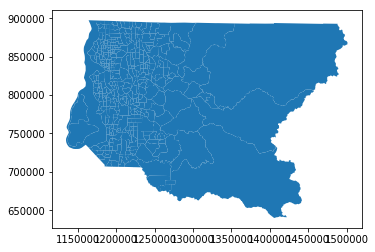

In [54]:
WA_tracts.plot()

In [55]:
# drop extraneous columns and rename census variables
extra_cols = ['STATEFP10', 'COUNTYFP10', 'ALAND10', 'AWATER10', 'TRACTCE10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 
             'INTPTLAT10', 'INTPTLON10', 'OBJECTID', 'Shape_Leng', 'Shape_Area', 'geometry']

WA_tracts = WA_tracts.drop(extra_cols, axis=1)
WA_tracts = WA_tracts.rename(index=str, columns = {'GEOID10': 'GEOID','POP10': 'population', 'NAME10': 'tract', 
                                                   'ALANDMI': 'Area in Land Miles'})

# calculate area and population density

WA_tracts['pop_den'] = WA_tracts['population'] / WA_tracts['Area in Land Miles']

WA_tracts['pop_den'] = WA_tracts['pop_den'].fillna(0)

WA_tracts.head(3)

,GEOID,population,Area in Land Miles,tract,pop_den
0,53033000100,6255,0.738,1.0,8475.609756
1,53033000200,7646,1.269,2.0,6025.216706
2,53033000300,2603,0.467,3.0,5573.875803


## Seattle Zoning Data

In [56]:
## import zoning data
sea_zones = gpd.read_file('/Users/perryjohnson/Desktop/Walkability/Data/Zoning_Detailed/Zoning_Detailed.shp')

print('Seattle Zoning Default CRS:', sea_zones.crs)

# drop extraneous columns
extra_cols = ['OVERLAY', 'CONTRACT', 'OBJECTID', 'ORDINANCE', 'EFFECTIVE', 'HISTORIC', 'SHORELINE', 'PEDESTRIAN',
              'MHA', 'MHA_VALUE', 'OVERLAY_PR', 'LIGHTRAIL', 'ZONELUT_DE', 'LIGHTRAIL_',
             'EFFECTIVE_', 'PEDESTRI_1', 'SHORELINE_', 'MIO_NAME', 'IZ',
             'ZONING_PRE', 'CONTRACT_P', 'HISTORIC_P', 'SHAPE_Leng', 'ORDINANCE_', 'ZONING_DES', 
             'BZONEID', 'DETAIL_DES', 'CATEGORY_D', 'ZONELUT', 'ZONING', 'BASE_ZONE', 'SHAPE_Area']

sea_zones = sea_zones.drop(extra_cols, axis = 1)

## remove null polygons (causes issues with merges)
sea_zones.shape
sea_zones = sea_zones[sea_zones.geometry.notnull()]

sea_zones.head(3)

Seattle Zoning Default CRS: {'init': 'epsg:4326'}


,ZONEID,CLASS_DESC,geometry
0,2985,Downtown,"POLYGON ((-122.3360890199357 47.6002610850185,..."
1,3792,Downtown,POLYGON ((-122.3259675488259 47.59453372968536...
2,3304,Major Institutions,POLYGON ((-122.2959369227568 47.65522891516646...


In [57]:
sea_zones['CLASS_DESC'].value_counts()

Commercial/Mixed Use        1262
Multi-Family                1243
Single Family                434
Major Institutions           287
Manufacturing/Industrial     220
Downtown                      97
Master Planned Community       2
Name: CLASS_DESC, dtype: int64

In [58]:
# lots of zoning information that needs to be cleaned into distinct groups
# Groups: commercial, industrial, residential

sea_zones['zone'] = sea_zones['CLASS_DESC']


## zoning designations to be generalized across the Bay Area
residential = ['Multi-Family', 'Single Family', 'Master Planned Community']
commercial = ['Commercial/Mixed Use', 'Downtown']
industrial = ['Major Institutions', 'Manufacturing/Industrial']


## simplify down to the above zoning designations
sea_zones['zone'] = sea_zones['zone'].replace(dict.fromkeys(residential, 'residential'))
sea_zones['zone'] = sea_zones['zone'].replace(dict.fromkeys(commercial, 'commercial'))
sea_zones['zone'] = sea_zones['zone'].replace(dict.fromkeys(industrial, 'industrial'))

print(sea_zones['zone'].unique())

['commercial' 'industrial' 'residential']


## Road Distance Features

In [59]:
#calculate closest road_type for each point within 300 meter buffer
EDF_points['road_type'] = EDF_points['geometry'].apply(find_closest_road, 
                                                       roads = sea_rds, buffer_dist = 0.0030)

In [60]:
## Calculate distance to nearest major roadway

# much faster to do the re-projection to meters outside of the apply function
EDF_utm = EDF_points.to_crs({'init': 'epsg:32610'}).copy()
highway_utm = sea_highways.to_crs({'init': 'epsg:32610'}).copy()
primary_utm = sea_primary.to_crs({'init': 'epsg:32610'}).copy()
secondary_utm = sea_secondary.to_crs({'init': 'epsg:32610'}).copy()

EDF_points['closest_highway'] = EDF_utm['geometry'].apply(distance_to_roadway, roadway = highway_utm)
EDF_points['closest_primary'] = EDF_utm['geometry'].apply(distance_to_roadway, roadway = primary_utm)
EDF_points['closest_secondary'] = EDF_utm['geometry'].apply(distance_to_roadway, roadway = secondary_utm)

In [61]:
## Calculate distance to nearest intersection and traffic signals
nodes_utm = nodes.to_crs({'init': 'epsg:32610'}).copy() #re-project as above
signals = nodes_utm[nodes_utm['highway'] == 'traffic_signals']

EDF_points['corner_dist'] = EDF_utm['geometry'].apply(nearest_intersection,
                                                            intersections = nodes_utm['geometry'])

EDF_points['signal_dist'] = EDF_utm['geometry'].apply(nearest_intersection, 
                                                               intersections = signals['geometry'])

In [62]:
# Cleaning road categories ...
EDF_points['road_type'] = EDF_points['road_type'].str.replace('_link', '')
EDF_points['road_type'] = np.where(EDF_points['road_type'] == 'trunk', 'secondary', EDF_points['road_type'])
EDF_points['road_type'] = np.where(EDF_points['road_type'] == 'living_street', 'residential', EDF_points['road_type'])
EDF_points['road_type'] = np.where(EDF_points['road_type'] == 'a', 'unclassified', EDF_points['road_type'])
EDF_points['road_type'] = np.where(EDF_points['road_type'] == 'razed', 'unclassified', EDF_points['road_type'])


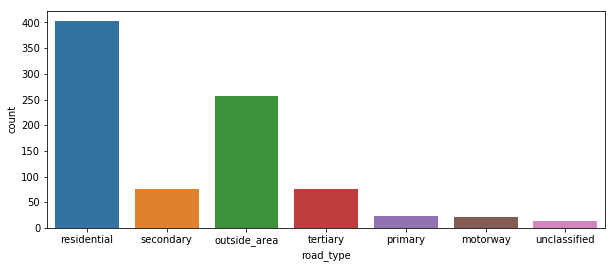

In [63]:
# Road Type Categories
plt.figure(figsize=(10,4))
sns.countplot(EDF_points['road_type']);

## Census and Zoning Features

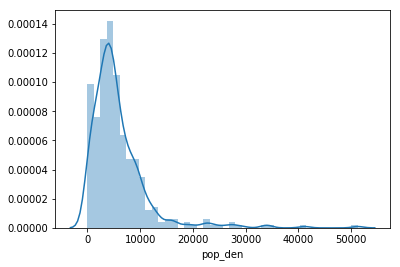

In [64]:
# population densities by census tract in King County
sns.distplot(WA_tracts['pop_den']);

In [65]:
# left merge with the zoning data
walk_all = gpd.sjoin(EDF_points, sea_zones, how='left', op='intersects')


# drop all observations that don't have a zone (thus aren't truly a part of Seattle or are perhaps in the water)
walk_all = walk_all.dropna()

# reset index from dropped null observations
walk_all = walk_all.reset_index(drop=True)

# remove unneeded columsn
walk_all = walk_all.drop(['index_right', 'CLASS_DESC', 'ZONEID'], axis = 1)


walk_all.head(3)

,lat,lon,walk_score,GEOID,intersection_count,streets_per_node_avg,circuity_avg,street_length_avg,restaurant_count,school_count,...,restaurantwide_count,geometry,place_name,road_type,closest_highway,closest_primary,closest_secondary,corner_dist,signal_dist,zone
0,47.555176,-122.315722,71,53033010402,51,2.873016,1.027668,55.858171,15,5,...,25,POINT (-122.3157218098284 47.55517615550175),"Seattle, King County, Washington, USA",residential,213.262697,988.209371,440.602524,41.665547,258.404482,residential
1,47.532400,-122.339537,5,53033011300,22,2.483871,1.263367,67.049229,0,1,...,3,POINT (-122.3395370513827 47.53240022665749),"Seattle, King County, Washington, USA",residential,360.439257,287.495654,581.799394,116.089690,580.289646,industrial
2,47.544541,-122.290044,76,53033011001,44,2.342857,1.039861,56.638507,16,5,...,31,POINT (-122.2900438765192 47.54454148634146),"Seattle, King County, Washington, USA",residential,1046.297088,1040.873612,363.888249,31.028696,640.466699,residential


In [66]:
#merge with the census data on GEOID
walk_all = pd.merge(walk_all, WA_tracts, on='GEOID')
walk_all.head(1)

,lat,lon,walk_score,GEOID,intersection_count,streets_per_node_avg,circuity_avg,street_length_avg,restaurant_count,school_count,...,closest_highway,closest_primary,closest_secondary,corner_dist,signal_dist,zone,population,Area in Land Miles,tract,pop_den
0,47.555176,-122.315722,71,53033010402,51,2.873016,1.027668,55.858171,15,5,...,213.262697,988.209371,440.602524,41.665547,258.404482,residential,4669,0.695,104.02,6717.985612


In [67]:
## Calculate distance to industrial zone
#re-projections
walk_utm = walk_all.to_crs({'init': 'epsg:32610'}).copy()
zones_utm = sea_zones.to_crs({'init': 'epsg:32610'}).copy()
industry = zones_utm[zones_utm.zone == 'industrial']
commercial = zones_utm[zones_utm.zone == 'commercial']
residential = zones_utm[zones_utm.zone == 'residential']

#calculations
walk_all['industry_dist'] = walk_utm['geometry'].apply(distance_to_zoning, zone = industry)
walk_all['commercial_dist'] = walk_utm['geometry'].apply(distance_to_zoning, zone = commercial)
walk_all['residential_dist'] = walk_utm['geometry'].apply(distance_to_zoning, zone = residential)

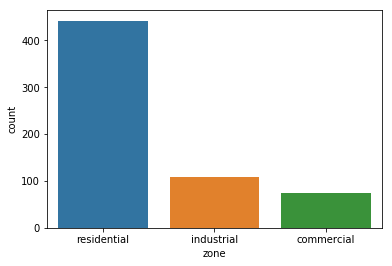

In [68]:
sns.countplot(walk_all['zone'])

# Amenity Features

1) Count of Schools within 1000 meter radius

2) Count of Parks within 1000 meter radius

3) Count of Restaurants within 1000 meter radius

4) Count of Supermarkets within 1000 meter radius

5) Count of Pubs within 1000 meter radius

6) Count of Bus Stations within 10000 meter radius

7) Count of Parks within 2500 meter radius

8) Count of Restaurants within 1500 meter radius

In [69]:
private_token = 'APIKEY'

def location_api(df, amenity, radius, apikey):
    amenity_count = [] 
    for i in range(len(df)):
        count = 0    
        url = 'https://us1.locationiq.com/v1/nearby.php?key='+apikey+'&lat='+str(df['lat'][i])+'&lon='+str(df['lon'][i])+'&tag='+amenity+'&radius='+radius+'&format=json'
        r = requests.get(url)
        data = r.json()
        if 'error' in data:
            amenity_count.append(0)
            print(data)
            time.sleep(0.75)
        else:   
            count = len(data)
            print(count)
            print(i)
            amenity_count.append(count)
            time.sleep(0.75)

    #df[amenity+'_count'] = amenity_count
    df[amenity+'wide_count'] = amenity_count
    
    return df

In [70]:
#locationiq amenity specs
amenity_specs = [['restaurant', '1000'], ['school', '1000'], ['park', '1000'], 
             ['bus_station', '10000'], ['supermarket', '1000'], ['pub', '1000'],
                ['parkwide', '2500'], ['restaurantwide', '1500']]

#walk_all = location_api(walk_all, 'restaurant', '1000', private_token);
#walk_all = location_api(walk_all, 'school', '1000', private_token);
#walk_all = location_api(walk_all, 'park', '1000', private_token);
#walk_all = location_api(walk_all, 'bus_station', '10000', private_token);
#walk_all = location_api(walk_all, 'supermarket', '1000', private_token);
#walk_all = location_api(walk_all, 'pub', '1000', private_token);
#walk_all = location_api(walk_all, 'park', '2500', private_token);
#walk_all = location_api(walk_all, 'restaurant', '1500', private_token);

In [71]:
# find the additional differential amenities outside of the inital search buffer
walk_all['restaurantdiff_count'] = walk_all['restaurantwide_count'] - walk_all['restaurant_count']
walk_all['parkdiff_count'] = walk_all['parkwide_count'] - walk_all['park_count']

In [72]:
# generate a total amenity score
walk_all['total_amenity'] = walk_all['bus_station_count'] + walk_all['school_count'] + walk_all['restaurant_count'] + walk_all['restaurantdiff_count'] + walk_all['supermarket_count'] + walk_all['park_count'] + walk_all['parkdiff_count'] + walk_all['pub_count']

In [73]:
walk_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 626 entries, 0 to 625
Data columns (total 35 columns):
lat                     626 non-null float64
lon                     626 non-null float64
walk_score              626 non-null int64
GEOID                   626 non-null int64
intersection_count      626 non-null int64
streets_per_node_avg    626 non-null float64
circuity_avg            626 non-null float64
street_length_avg       626 non-null float64
restaurant_count        626 non-null int64
school_count            626 non-null int64
park_count              626 non-null int64
bus_station_count       626 non-null int64
supermarket_count       626 non-null int64
pub_count               626 non-null int64
parkwide_count          626 non-null int64
restaurantwide_count    626 non-null int64
geometry                626 non-null object
place_name              626 non-null object
road_type               626 non-null object
closest_highway         626 non-null float64
closest_prim

In [74]:
master = pd.read_csv('Data/master_features.csv', index_col=0)
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7158 entries, 0 to 7157
Data columns (total 35 columns):
Area in Land Miles      7158 non-null float64
GEOID                   7158 non-null int64
bus_station_count       7158 non-null int64
circuity_avg            7157 non-null float64
closest_highway         7158 non-null float64
closest_primary         7158 non-null float64
closest_secondary       7158 non-null float64
commercial_dist         7158 non-null float64
corner_dist             7158 non-null float64
geometry                7158 non-null object
industry_dist           7158 non-null float64
intersection_count      7158 non-null int64
lat                     7158 non-null float64
lon                     7158 non-null float64
park_count              7158 non-null int64
parkdiff_count          7158 non-null int64
parkwide_count          7158 non-null int64
place_name              7158 non-null object
pop_den                 7158 non-null float64
population              7158 non-

In [75]:
# merge in most recent data collection with master data collection
merged = pd.concat([master, walk_all], ignore_index=True)
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7784 entries, 0 to 7783
Data columns (total 35 columns):
Area in Land Miles      7784 non-null float64
GEOID                   7784 non-null int64
bus_station_count       7784 non-null int64
circuity_avg            7783 non-null float64
closest_highway         7784 non-null float64
closest_primary         7784 non-null float64
closest_secondary       7784 non-null float64
commercial_dist         7784 non-null float64
corner_dist             7784 non-null float64
geometry                7784 non-null object
industry_dist           7784 non-null float64
intersection_count      7784 non-null int64
lat                     7784 non-null float64
lon                     7784 non-null float64
park_count              7784 non-null int64
parkdiff_count          7784 non-null int64
parkwide_count          7784 non-null int64
place_name              7784 non-null object
pop_den                 7784 non-null float64
population              7784 non-

/Users/perryjohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [76]:
merged.to_csv('Data/master_features.csv')

## Model Development

In [77]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import clone

In [78]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color='black')

def pred_summary(pred, ytest, limit = 100):
    """Plotting for test set predictions"""
    sns.scatterplot(pred, ytest)
    abline(1, 0) 
    plt.ylim(0, limit); plt.xlim(0, limit)
    plt.tick_params(labelsize=18)
    
    print('RMSE', np.sqrt(mean_squared_error(ytest, pred)))
    print('R2', r2_score(ytest, pred))
    

In [79]:
merged = merged.replace([np.inf, -np.inf], np.nan)
walk_model = merged.dropna() # remove the few NA values if there are any

# Grab relevant features
X_vars = ['closest_highway', 'closest_primary', 'closest_secondary', 'corner_dist', 'signal_dist', 'zone',
          'industry_dist', 'commercial_dist', 'residential_dist', 'school_count', 'park_count', 'restaurant_count',
         'bus_station_count', 'supermarket_count', 'pub_count', 'parkdiff_count', 'Area in Land Miles', 'population',
         'pop_den', 'restaurantdiff_count', 'intersection_count','streets_per_node_avg', 'circuity_avg', 'street_length_avg',
         'total_amenity']

X = walk_model[X_vars]
X = pd.get_dummies(X, columns=['zone']) #create dummy variables for categorical features


#X = X.drop(['road_type_motorway', 'road_type_primary', 'road_type_secondary'], axis = 1)

y = walk_model['walk_score']

#train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=0)
print('Train size:', len(ytrain))
print('Test size:', len(ytest))

Train size: 5214
Test size: 2569


In [80]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7783 entries, 0 to 7783
Data columns (total 27 columns):
closest_highway         7783 non-null float64
closest_primary         7783 non-null float64
closest_secondary       7783 non-null float64
corner_dist             7783 non-null float64
signal_dist             7783 non-null float64
industry_dist           7783 non-null float64
commercial_dist         7783 non-null float64
residential_dist        7783 non-null float64
school_count            7783 non-null int64
park_count              7783 non-null int64
restaurant_count        7783 non-null int64
bus_station_count       7783 non-null int64
supermarket_count       7783 non-null int64
pub_count               7783 non-null int64
parkdiff_count          7783 non-null int64
Area in Land Miles      7783 non-null float64
population              7783 non-null int64
pop_den                 7783 non-null float64
restaurantdiff_count    7783 non-null int64
intersection_count      7783 non-null

In [81]:
forest = RandomForestRegressor(n_jobs=2)

# Number of trees in random forest
n_estimators = [300, 400, 500, 600, 700, 800]
# Number of features to consider at every split
max_features = [2, 3, 4, 5, 6, 7]
# Maximum number of levels in tree
max_depth = [20, 22, 24]
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
              'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

forest_grid = RandomizedSearchCV(forest, param_distributions= random_grid, 
                                 cv = 5, scoring= 'neg_mean_squared_error')

forest_grid.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [300, 400, 500, 600, 700, 800], 'max_features': [2, 3, 4, 5, 6, 7], 'max_depth': [20, 22, 24], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [82]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(forest_grid.best_score_)))
print(forest_grid.best_estimator_)
Xtrain.columns

Best score (RMSE) 6.5410296856139265
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=600, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


Index(['closest_highway', 'closest_primary', 'closest_secondary',
       'corner_dist', 'signal_dist', 'industry_dist', 'commercial_dist',
       'residential_dist', 'school_count', 'park_count', 'restaurant_count',
       'bus_station_count', 'supermarket_count', 'pub_count', 'parkdiff_count',
       'Area in Land Miles', 'population', 'pop_den', 'restaurantdiff_count',
       'intersection_count', 'streets_per_node_avg', 'circuity_avg',
       'street_length_avg', 'total_amenity', 'zone_commercial',
       'zone_industrial', 'zone_residential'],
      dtype='object')

RMSE 6.146275853308151
R2 0.9412065544840987


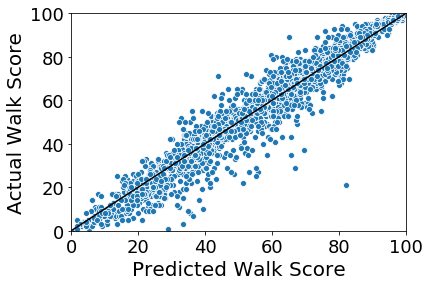

In [83]:
forest_out = forest_grid.predict(Xtest)
pred_summary(forest_out, ytest, limit=100)
plt.xlabel('Predicted Walk Score', fontsize = 20); plt.ylabel('Actual Walk Score', fontsize=20);

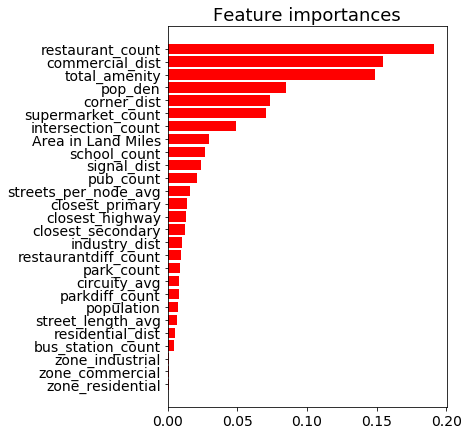

In [84]:
features = X.columns
importance = forest_grid.best_estimator_.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="r",  align="center")
plt.tick_params(labelsize=14);

In [85]:
gbr = GradientBoostingRegressor()

params = {'max_features': [6, 8, 10, 12],
          'n_estimators': [400, 500, 600, 700]}

gbr_grid = RandomizedSearchCV(gbr, params, cv=5, scoring = 'neg_mean_squared_error')

gbr_grid.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_features': [6, 8, 10, 12], 'n_estimators': [400, 500, 600, 700]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [86]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(gbr_grid.best_score_)))
print(gbr_grid.best_estimator_)

Best score (RMSE) 6.8030666881818584
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=8,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=700, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


RMSE 6.509395714461238
R2 0.9340543484706957


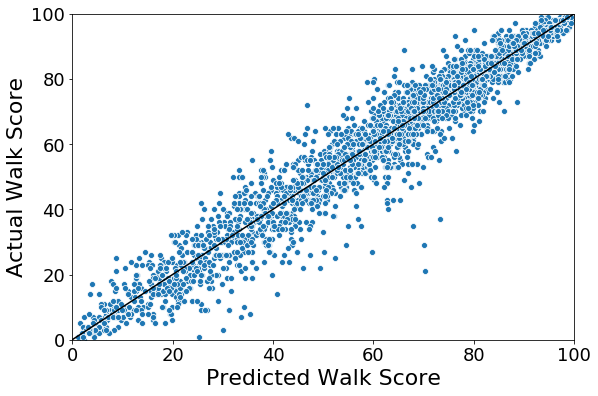

In [87]:
fig = plt.figure(figsize=(9,6))
gbr_out = gbr_grid.predict(Xtest)
pred_summary(gbr_out, ytest, limit=100)
plt.xlabel('Predicted Walk Score', fontsize = 22); plt.ylabel('Actual Walk Score', fontsize=22);

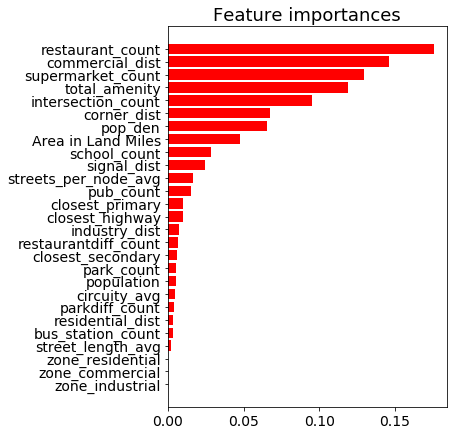

In [88]:
features = X.columns
importance = gbr_grid.best_estimator_.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="r",  align="center")
plt.tick_params(labelsize=14);

In [89]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    'eval_metric': ['rmse'],
    'max_depth': [2, 4, 6, 8, 10],
    'n_estimators': [100, 500, 750, 1000]
}



# Create a based model
xgb = XGBRegressor()


# Instantiate the grid search model
xgb_grid_search = RandomizedSearchCV(estimator = xgb, param_distributions= param_grid, 
                         cv = 5, n_jobs = -1)

# fit the model
xgb_grid_search.fit(Xtrain, ytrain)

/Users/perryjohnson/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1], 'eval_metric': ['rmse'], 'max_depth': [2, 4, 6, 8, 10], 'n_estimators': [100, 500, 750, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [90]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(xgb_grid_search.best_score_)))
print(xgb_grid_search.best_estimator_)

Best score (RMSE) 0.9696221799382234
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


RMSE 5.904185960226612
R2 0.945746860920979


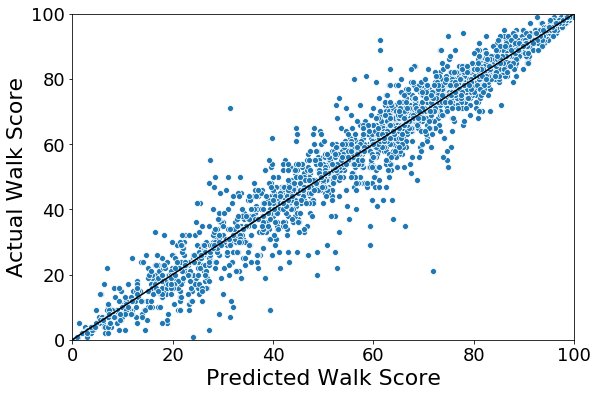

In [91]:
fig = plt.figure(figsize=(9,6))
xgb_out = xgb_grid_search.predict(Xtest)
pred_summary(xgb_out, ytest, limit=100)
plt.xlabel('Predicted Walk Score', fontsize = 22); plt.ylabel('Actual Walk Score', fontsize=22);

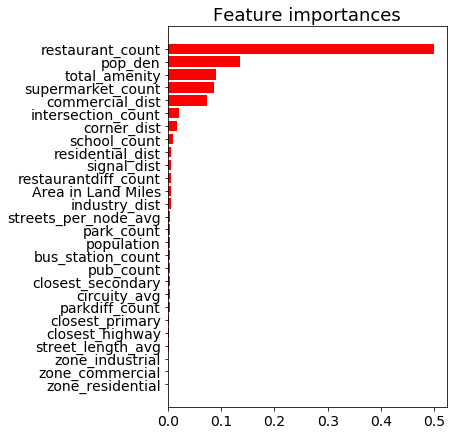

In [92]:
features = X.columns
importance = xgb_grid_search.best_estimator_.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="r",  align="center")
plt.tick_params(labelsize=14);

# Additional Visuals for Presentation

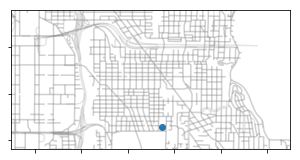

In [94]:
## Plot single point for feature engineering slide
fig, ax = plt.subplots(1, figsize=(5,5))
base = edges.plot(ax=ax, color='gray', alpha=0.2)
plt.scatter(merged.lon.iloc[2000:2002], merged.lat.iloc[2000:2002])
ax.set_xlim(-122.335167, -122.275167); ax.set_ylim(47.568013, 47.598013)
ax.grid(False)
ax.set_facecolor('xkcd:white')
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([]);
fig.savefig('Visuals/spatial_example.png', format='png', dpi=300)